# 这个是人家的
https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../src')
import tensorflow as tf
import tensorflow.keras as k
import pandas as pd
import numpy as np
import test_submit
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[7], 'GPU')

In [4]:
train = pd.read_pickle('../inputs/dataset/train.pkl')
investment_id = train.pop('investment_id')
y = train.pop('target')

In [6]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = k.layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

2022-03-05 10:46:12.462411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38411 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-03-05 10:46:12.463529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38411 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-03-05 10:46:12.464613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38411 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2022-03-05 10:46:12.465689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38411 MB memory:  -> device: 3, name: A100-SXM4-40GB, pci bus id: 0000:4e:00.0, compute 

In [13]:
from tensorflow.python.ops import math_ops

features = [f'f_{i}' for i in range(300)]
batch_size = 1024
epochs = 30

def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr


    
def get_model():
    # activation = 'relu'
    # kernel_regularizer = None
    activation = 'swish'
    kernel_regularizer = 'l2'

    investment_id_inputs = k.Input((1, ), dtype=tf.uint16)
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = k.layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = k.layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)
    investment_id_x = k.layers.Dropout(.1)(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)
    investment_id_x = k.layers.Dropout(.1)(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)
    investment_id_x = k.layers.Dropout(.1)(investment_id_x)
    


    feature_inputs = k.Input((300,), dtype=tf.float16)
    feature_x = k.layers.Dense(256, activation=activation)(feature_inputs)
    feature_x = k.layers.Dropout(.1)(feature_x)
    feature_x = k.layers.Dense(256, activation=activation)(feature_x)
    feature_x = k.layers.Dropout(.1)(feature_x)
    feature_x = k.layers.Dense(256, activation=activation)(feature_x)
    feature_x = k.layers.Dropout(.1)(feature_x)

    x = k.layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = k.layers.Dense(512, activation=activation, kernel_regularizer=kernel_regularizer)(x)
    x = k.layers.Dropout(.1)(x)
    x = k.layers.Dense(128, activation=activation, kernel_regularizer=kernel_regularizer)(x)
    x = k.layers.Dropout(.1)(x)
    x = k.layers.Dense(32, activation=activation, kernel_regularizer=kernel_regularizer)(x)
    x = k.layers.Dropout(.1)(x)

    # output = k.layers.Dense(1, activation='sigmoid')(x)
    output = k.layers.Dense(1)(x)

    model = k.Model(inputs=[investment_id_inputs, feature_inputs], outputs=[output])
    rmse = k.metrics.RootMeanSquaredError(name="rmse")
    model.compile(optimizer=k.optimizers.Adam(0.001), loss='mse', metrics=['mse', 'mae', 'mape', rmse, correlation])

    return model

def eval(model):
    return test_submit.eval(lambda test: model.predict(test[features]))

def make_dataset(feature, y, investment_id, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds





In [9]:
# import pickle
# def cal_pearson(investment_id, y, pred_y):
#     investment_id = pickle.load(open('investment_id.dump', 'rb'))
#     y = pickle.load(open('y.dump', 'rb'))
#     pred_y = pickle.load(open('pred_y.dump', 'rb'))
    
#     df = pd.DataFrame({
#         'id': investment_id,
#         'y': y,
#         'pred_y': pred_y
#     })


#     return df

# t = cal_pearson(1,1,1)
# # stats.pearsonr(ds.y, ds.pred_y)
# [ds.shape  for _, ds in t.groupby('id') if ds.shape[0] <=2]

In [19]:
from sklearn.model_selection import KFold, StratifiedKFold

models = []
# kfold = KFold(5, shuffle=True, random_state=23)
kfold = StratifiedKFold(5, shuffle=True, random_state=23)

for i, (train_indices, target_indices) in enumerate(kfold.split(train[features], investment_id)):
    X_train, X_val = train.loc[train_indices, features], train.loc[target_indices, features]
    y_train, y_val = y.loc[train_indices], y.loc[target_indices]
    investment_id_train, investment_id_val = investment_id.loc[train_indices], investment_id.loc[target_indices]
    train_ds = make_dataset(X_train, y_train, investment_id_train)
    val_ds = make_dataset(X_val, y_val, investment_id_val, mode='val')

    model = get_model()

    if False:
        # checkpoint = k.callbacks.ModelCheckpoint(f'../outputs/models/simple_nn_{i}', save_best_only=True)
        checkpoint = k.callbacks.ModelCheckpoint(f'../outputs/models/simple_nn_v2_{i}', monitor="val_correlation", mode='min', save_best_only=True)
        earlystopping = k.callbacks.EarlyStopping(patience=10)
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[checkpoint, earlystopping]
        )
        # model.load_weights(f'../outputs/models/simple_nn_v2_{i}.tf')
        k.models.load_model(f'../outputs/models/simple_nn_v2_{i}')
        for metric in ['mse', 'mae', 'mape', 'rmse', 'correlation']:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        k.models.load_model(f'../outputs/models/simple_nn_v2_{i}', custom_objects={'correlation':correlation})
        # model.save(f'../outputs/models/simple_nn_v2_{i}')

    models.append(model)

    pearson_score = stats.pearsonr(model.predict(val_ds).ravel(), y_val.values)
    print('Pearson:', pearson_score)
    

/opt/conda/envs/ubiquant/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Pearson: (-0.03953245016630803, 1.0593356618539348e-215)


Pearson: (-0.04612899548287325, 5.291394585491052e-293)


Pearson: (-0.03179741681864361, 3.0880875144633935e-140)


Pearson: (-0.008841287605185785, 2.4157166964225596e-12)


Pearson: (-0.017457501861086525, 1.4911633093070433e-43)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 32)        114560      integer_lookup[5][0]             
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 300)]        0                                            
____________________________________________________________________________________________

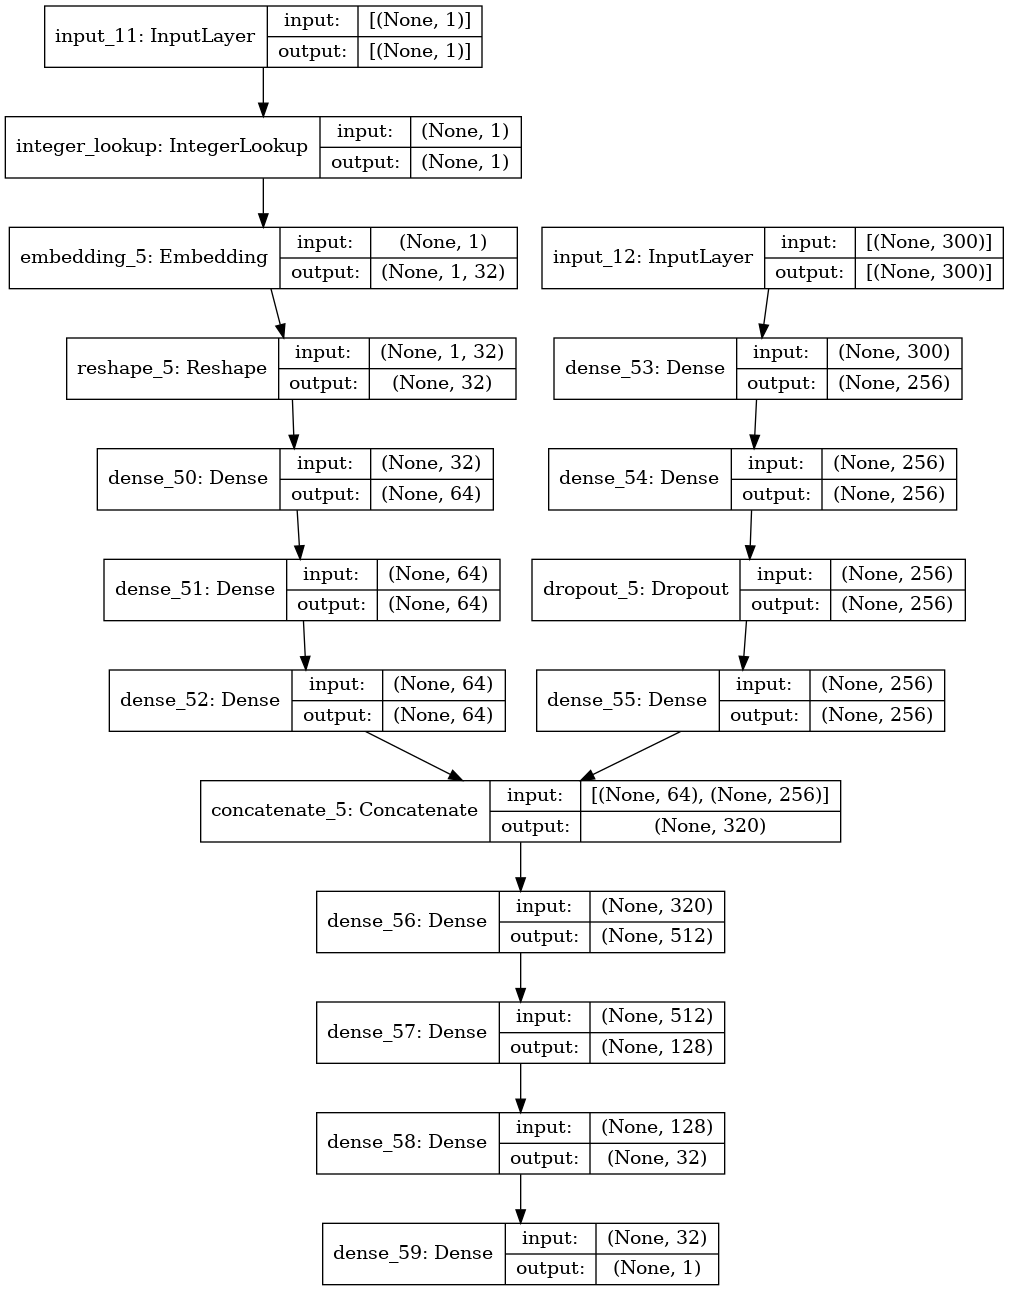

In [7]:
model = get_model()
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [8]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

# def preprocess_test(feature):
#     return feature, 0

def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
#     ds = tf.data.Dataset.from_tensor_slices(feature)
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0).ravel()
    

models = []
for i in range(5):
    models.append(k.models.load_model(f'../outputs/models/simple_nn_{i}'))




test_df = pd.read_csv('../inputs/dataset/example_test.csv')
sample_prediction_df = pd.read_csv('../inputs/dataset/example_sample_submission.csv')
ds = make_test_dataset(test_df[features],  test_df["investment_id"])
sample_prediction_df['target'] = inference(models, ds)

2022-03-03 23:47:15.324901: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-03-03 23:47:15.324945: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
sample_prediction_df

row_id  time_id    target
0  1220_1     1220 -0.057361
1  1220_2     1220  0.038725
2  1221_0     1221 -0.043847
3  1221_1     1221 -0.019396
4  1221_2     1221 -0.101181
5  1222_0     1222 -0.052097
6  1222_1     1222  0.002587
7  1222_2     1222 -0.025135
8  1223_0     1223 -0.015279